Imports and constants assignation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[]

In [17]:

### Constants
samples_per_record = 3327
fs = 16000
inputs = []
outputs = []
flag = True

# List of commands that the nn will recognize
# commands = ['noise','go', 'take','bring','cancel','one','two','three','four','five','six','seven']
commands = ['noise','cancel','one','two','three','four','five','six','seven']
# commands = ['noise', 'take','bring','go','cancel']
num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2


Data parse

In [18]:

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)
  # print('\tSorting ',command)
  
  # convert the list to numpy array
  inputs = np.array(inputs)
  outputs = np.array(outputs)

  if flag:
      inputs_train = np.empty((0,inputs.shape[1],inputs.shape[2]))
      inputs_test = np.empty((0,513,5))
      inputs_validate = np.empty((0,513,5))
      outputs_train = np.empty((0,outputs.shape[1]))
      outputs_test = np.empty((0,outputs.shape[1]))
      outputs_validate = np.empty((0,outputs.shape[1]))
      temp_inputs_train = np.empty((0,513,5))
      temp_inputs_test = np.empty((0,513,5))
      temp_inputs_validate = np.empty((0,513,5))
      temp_outputs_train = np.empty((0,outputs.shape[1]))
      temp_outputs_test = np.empty((0,outputs.shape[1]))
      temp_outputs_validate = np.empty((0,outputs.shape[1]))
      flag = False

  # Sort inputs randomly
  num_inputs = len(inputs)
  random_idx = np.arange(num_inputs)
  np.random.shuffle(random_idx)

  inputs = inputs[random_idx]
  outputs = outputs[random_idx]

  # Split the inputs into: training (60%), testing(20%) and validation(20%)
  train_idx = int(0.8 * num_inputs)
  test_idx = int(0.1 * num_inputs + train_idx)

  temp_inputs_train, temp_inputs_test, temp_inputs_validate = np.split(inputs, [train_idx, test_idx])
  temp_outputs_train, temp_outputs_test, temp_outputs_validate = np.split(outputs, [train_idx, test_idx])
  
  
  inputs_train = np.vstack([inputs_train, temp_inputs_train])
  inputs_test = np.vstack([inputs_test, temp_inputs_test])
  inputs_validate = np.vstack([inputs_validate, temp_inputs_validate])
  # print('Inputs train shape: ',inputs_train.shape)

  outputs_train = np.vstack([outputs_train, temp_outputs_train])
  outputs_test = np.vstack([outputs_test, temp_outputs_test])
  outputs_validate = np.vstack([outputs_validate, temp_outputs_validate])

  inputs = []
  outputs = [] 

print("Data set parsing and preparation complete.")

Processing index 0 for command 'noise'.
	There are 291 recordings of the noise command.
Processing index 1 for command 'cancel'.
	There are 311 recordings of the cancel command.
Processing index 2 for command 'one'.
	There are 305 recordings of the one command.
Processing index 3 for command 'two'.
	There are 299 recordings of the two command.
Processing index 4 for command 'three'.
	There are 300 recordings of the three command.
Processing index 5 for command 'four'.
	There are 309 recordings of the four command.
Processing index 6 for command 'five'.
	There are 373 recordings of the five command.
Processing index 7 for command 'six'.
	There are 330 recordings of the six command.
Processing index 8 for command 'seven'.
	There are 319 recordings of the seven command.
Data set parsing and preparation complete.


Randomize samples

In [19]:

num_inputs = len(inputs_train)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs_train = inputs_train[random_idx]
outputs_train = outputs_train[random_idx]

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [20]:
from tensorflow.keras import regularizers
# build the model and train it

# Define the input shape
input_shape = (inputs_train[1].shape)

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 32
filter_size_layer_1 = (5,5)
filter_size_layer_2 = (3,3)

model = 0
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*2, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Conv2D(filters=filters_layer_1*4, padding='same', kernel_size=filter_size_layer_2,
                                activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 513, 32)        1472      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 256, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 256, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 128, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 128, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 64, 128)      

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=4,
                    validation_data=(inputs_validate, outputs_validate),
                    callbacks=[early_stopping])

Epoch 1/100
567/567 [==============================] - 35s 54ms/step - loss: 1.5535 - accuracy: 0.5395 - val_loss: 0.9742 - val_accuracy: 0.7276
Epoch 2/100
567/567 [==============================] - 29s 51ms/step - loss: 0.9629 - accuracy: 0.7380 - val_loss: 0.7309 - val_accuracy: 0.8207
Epoch 3/100
567/567 [==============================] - 31s 54ms/step - loss: 0.8090 - accuracy: 0.7958 - val_loss: 0.6050 - val_accuracy: 0.8724
Epoch 4/100
567/567 [==============================] - 29s 52ms/step - loss: 0.6740 - accuracy: 0.8377 - val_loss: 0.4528 - val_accuracy: 0.9172
Epoch 5/100
567/567 [==============================] - 30s 53ms/step - loss: 0.6605 - accuracy: 0.8461 - val_loss: 0.5881 - val_accuracy: 0.8862
Epoch 6/100
567/567 [==============================] - 30s 53ms/step - loss: 0.6461 - accuracy: 0.8681 - val_loss: 0.4473 - val_accuracy: 0.9172
Epoch 7/100
567/567 [==============================] - 30s 52ms/step - loss: 0.5451 - accuracy: 0.8769 - val_loss: 0.4353 - val_ac

Loss graph

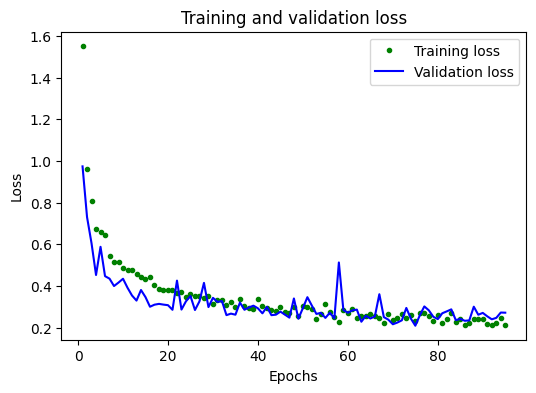

In [22]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


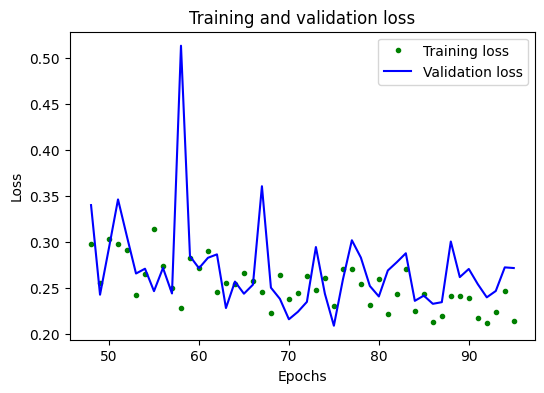

In [23]:
# graph the loss again skipping a bit of the start
SKIP = int(len(epochs)/2)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy graph

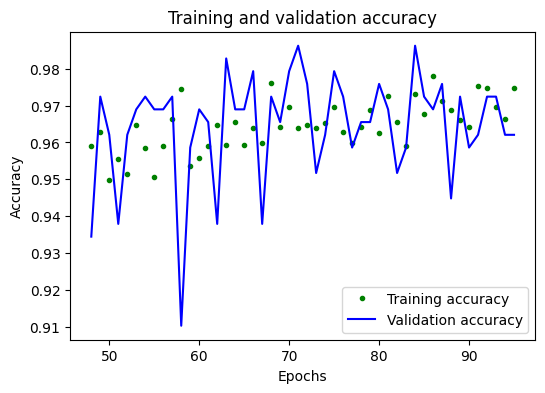

In [24]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Test model predictions

9/9 [==============================] - 1s 62ms/step
class: 9


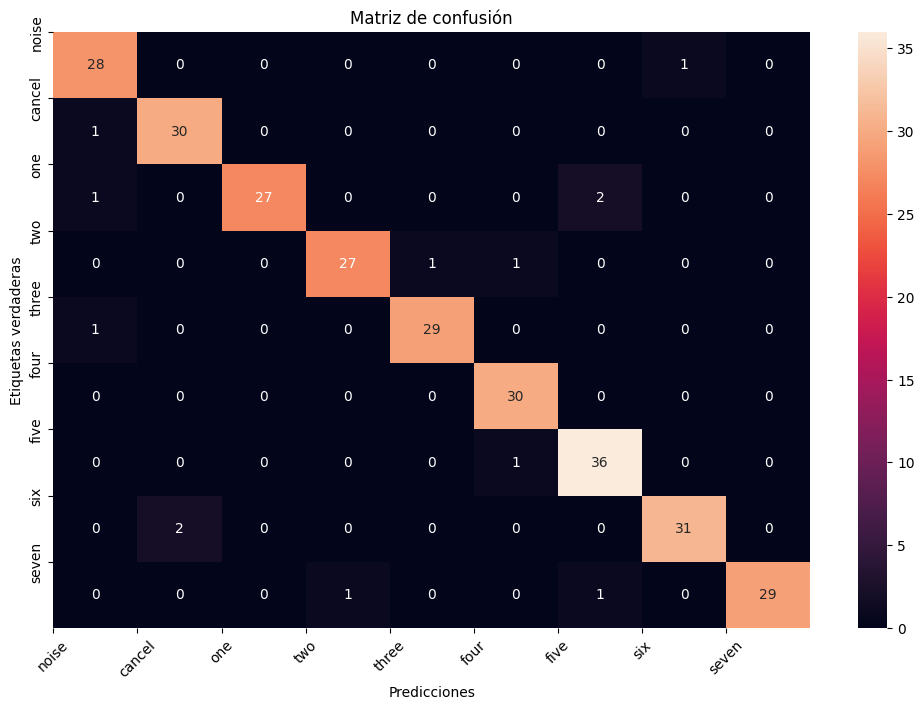

Accuracy: 0.9535714285714286


In [25]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    confusion_matrix[true_class][predicted_class] += 1
# print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
# plt.imshow(confusion_matrix, cmap=plt.cm.Blues, annot=True)
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix, annot=True)
plt.title("Matriz de confusión")
# plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

## Accuracy

total_correct = 0
for i in range(num_classes):
    total_correct += confusion_matrix[i][i]

total = np.sum(confusion_matrix)
accuracy = total_correct / total

print('Accuracy:', accuracy)


Convert model to tensorflow lite

In [26]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("numbers_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("numbers_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\oscar\AppData\Local\Temp\tmpp5qwfvp7\assets


INFO:tensorflow:Assets written to: C:\Users\oscar\AppData\Local\Temp\tmpp5qwfvp7\assets


Model is 3072828 bytes
